In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from abc import ABC, abstractmethod


class InterestRateModel(ABC):
    """
    Base class for interest rate models. This class provides a common interface 
    for all interest rate models like Ho-Lee, Vasicek, etc.
    """

    def __init__(self, r0: float = None):
        """
        Initializes the interest rate model.

        Parameters:
        r0 (float): Initial interest rate (starting point of the process).
        """
        self.r0 = r0

    @abstractmethod
    def calibrate(self, rates: np.ndarray, dt: float = 1 / 252, method: str = "mle") -> None:
        """
        Calibrate the model parameters using historical rate data.
        This method should be implemented by subclasses.
        """
        pass

    @abstractmethod
    def simulate_path(self, N: int, dt: float = 1 / 252) -> List[float]:
        """
        Simulate a single path of the interest rate process.

        Args:
        N: Number of time steps (integer).
        dt: Time step (float, default is daily).
        
        Returns:
        A list of simulated rates over time.

        Raises:
        NotImplementedError: If this method is not implemented in a subclass.
        """
        pass

    def simulate_paths(self, M: int, N: int, dt: float = 1 / 252) -> np.ndarray:
        """
        Simulates multiple paths of the interest rate model.

        Parameters:
        M (int): Number of paths.
        N (int): Number of time steps.
        dt (float): Time increment (default is daily).

        Returns:
        np.ndarray: Simulated paths of interest rates.
        """
        return np.array([self.simulate_path(N, dt) for _ in range(M)])

    def plot_simulation(self, paths: np.ndarray, title: str = "Simulation with Calibrated Parameters") -> None:
        """
        Plots the simulation results for multiple paths, including the upper bound, lower bound, and average.
    
        Parameters:
        paths (np.ndarray): Array of simulated paths.
        title (str): Title of the plot.
        """
        time = np.arange(paths.shape[1]) / 252  # Convert time to years
        plt.figure(figsize=(10, 6))
    
        # Plot each individual path
        for path in paths:
            plt.plot(time, path, lw=0.5, alpha=0.6)
    
        # Calculate the upper bound, lower bound, and average across all paths
        upper_bound = np.percentile(paths, 95, axis=0)  # 95th percentile as upper bound
        lower_bound = np.percentile(paths, 5, axis=0)   # 5th percentile as lower bound
        average = np.mean(paths, axis=0)  # Mean as average
    
        # Plot the upper bound, lower bound, and average
        plt.plot(time, upper_bound, label="Upper Bound (95th Percentile)", color='red', lw=2, linestyle='--')
        plt.plot(time, lower_bound, label="Lower Bound (5th Percentile)", color='blue', lw=2, linestyle='--')
        plt.plot(time, average, label="Average", color='green', lw=2)
    
        # Add labels and title
        plt.title(title)
        plt.xlabel("Time (years)")
        plt.ylabel("Interest Rate")
        plt.legend()
        plt.grid(True)
        plt.show()


class VasicekModel(InterestRateModel):
    """
    Vasicek interest rate model. Inherits from InterestRateModel base class.
    """

    def __init__(self, kappa: float = None, theta: float = None, sigma: float = None, r0: float = None):
        """
        Initializes the Vasicek model with the given parameters.

        Parameters:
        kappa (float): Mean-reversion rate.
        theta (float): Long-term mean level.
        sigma (float): Volatility.
        r0 (float): Initial rate.
        """
        super().__init__(r0)
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma

    def calibrate(self, rates: np.ndarray, dt: float = 1 / 252, method: str = "mle") -> None:
        """
        Calibrate the Vasicek model parameters using historical rate data.
        
        Args:
        rates: Historical interest rate data (numpy array).
        dt: Time step (float, default is daily).
        method: Method for calibration, either 'mle' for Maximum Likelihood Estimation or 'least_squares' for Least Squares.
        """
        if method == "mle":
            # MLE calibration (maximum likelihood estimation)
            n = len(rates)
            Sx = np.sum(rates[:-1])  # Sum of rates at time t
            Sy = np.sum(rates[1:])  # Sum of rates at time t+1
            Sxx = np.dot(rates[:-1], rates[:-1])  # Sum of squares of rates at time t
            Sxy = np.dot(rates[:-1], rates[1:])  # Sum of product of rates at t and t+1
            Syy = np.dot(rates[1:], rates[1:])  # Sum of squares of rates at time t+1

            # Solving for model parameters using least-squares fitting
            self.theta = (Sy * Sxx - Sx * Sxy) / (n * (Sxx - Sxy) - (Sx ** 2 - Sx * Sy))
            self.kappa = -np.log((Sxy - self.theta * Sx - self.theta * Sy + n * self.theta ** 2) / (
                    Sxx - 2 * self.theta * Sx + n * self.theta ** 2)) / dt
            a = np.exp(-self.kappa * dt)
            sigma_h2 = (
                               Syy
                               - 2 * a * Sxy
                               + a ** 2 * Sxx
                               - 2 * self.theta * (1 - a) * (Sy - a * Sx)
                               + n * self.theta ** 2 * (1 - a) ** 2
                       ) / n
            self.sigma = np.sqrt(sigma_h2 * 2 * self.kappa / (1 - a ** 2))

        elif method == "least_squares":
            # Least Squares calibration (Linear regression)
            r0 = rates[:-1].reshape(-1, 1)  # Previous rates
            r1 = rates[1:]  # Next rates
            reg = LinearRegression().fit(r0, r1)

            # Estimation of parameters using linear regression
            a_LS = (1 - reg.coef_[0]) / dt
            b_LS = reg.intercept_ / dt / a_LS

            # Estimation of sigma
            epsilon = r1 - r0.flatten() * reg.coef_[0]
            sigma_LS = np.std(epsilon) / np.sqrt(dt)

            # Set the model parameters
            self.kappa = a_LS
            self.theta = b_LS
            self.sigma = sigma_LS

        else:
            raise ValueError("Invalid method. Choose 'mle' or 'least_squares'.")

    def simulate_path(self, N: int, dt: float = 1 / 252) -> List[float]:
        """
        Simulate a single path of the interest rate process using the Euler-Maruyama scheme.

        Args:
        N: Number of time steps (integer).
        dt: Time step (float, default is daily).
        
        Returns:
        A list of simulated rates over time.
        """
        rates = np.zeros(N)
        rates[0] = self.r0

        for i in range(1, N):
            # Simulate next rate using the Euler-Maruyama scheme
            rates[i] = self.next_rate(rates[i - 1], dt)

        return rates

    def next_rate(self, r: float, dt: float = 1 / 252) -> float:
        """
        Simulate the next rate using the Euler-Maruyama scheme.
    
        Args:
        r (float): Current rate.
        dt (float): Time increment (default is daily).
    
        Returns:
        float: Simulated next rate.
        """
        # Using self.kappa, self.theta, and self.sigma from the object
        val1 = np.exp(-self.kappa * dt)  # Discount factor for mean-reversion
        val2 = (self.sigma ** 2) * (1 - val1 ** 2) / (2 * self.kappa)  # Variance term
        new_rate = r * val1 + self.theta * (1 - val1) + np.sqrt(val2) * np.random.normal()
        return new_rate



Data preparation:

C:\Users\annam\AppData\Local\Temp\ipykernel_12432\3975803621.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  treasury_df['Date'] = pd.to_datetime(treasury_df['Date'])


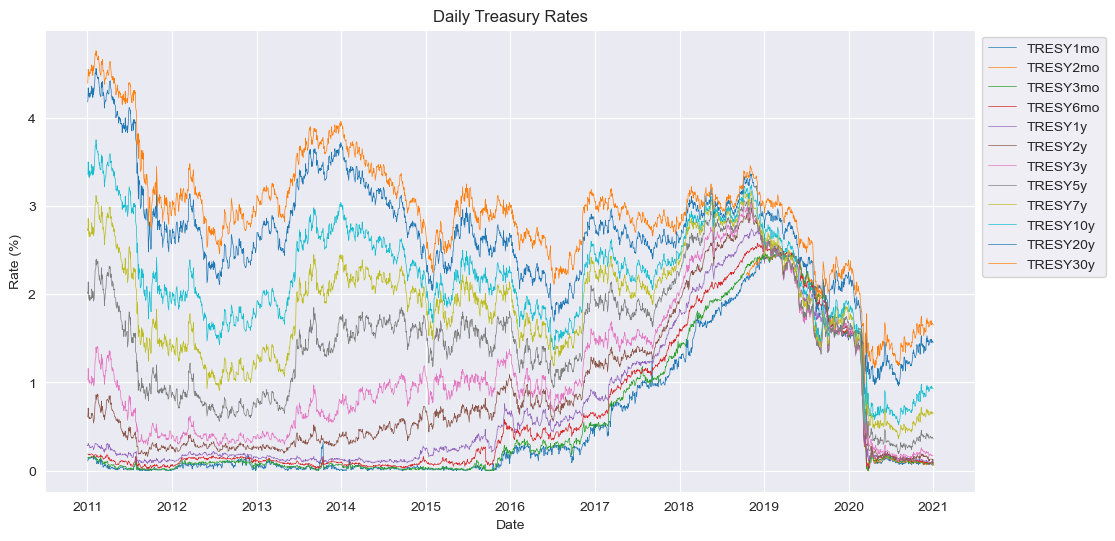

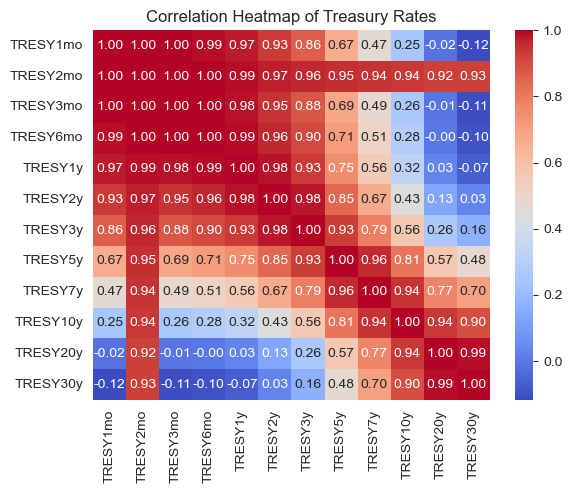

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression


data_file = 'yield-curve-rates-2011-2020.csv'
treasury_df = pd.read_csv(data_file)


treasury_df['Date'] = pd.to_datetime(treasury_df['Date'])
treasury_df.set_index('Date', inplace=True)
treasury_df.columns = [
    'TRESY1mo', 'TRESY2mo', 'TRESY3mo', 'TRESY4mo', 'TRESY6mo', 'TRESY1y',
    'TRESY2y', 'TRESY3y', 'TRESY5y', 'TRESY7y', 'TRESY10y', 'TRESY20y', 'TRESY30y'
]


treasury_df.drop(columns=['TRESY4mo'], inplace=True)

def plot_rates(df):
    plt.figure(figsize=(12, 6))
    for column in df.columns:
        plt.plot(df.index, df[column], label=column, lw=0.5)
    plt.title("Daily Treasury Rates")
    plt.xlabel("Date")
    plt.ylabel("Rate (%)")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.show()

plot_rates(treasury_df)

sns.heatmap(treasury_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Heatmap of Treasury Rates")
plt.show()

# Selection of data for calibration (e.g., interest rates for 10-year bonds)
rates_10y = treasury_df['TRESY10y'].dropna() / 100


C:\Users\annam\AppData\Local\Temp\ipykernel_12432\312065330.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vasicek = VasicekModel(r0=rates_10y[-1])  # Using the last rate as the initial rate



Vasicek Model Parameters (mle):
Kappa: 0.7085
Theta: 0.0252
Sigma: 0.0075
Initial Rate (r0): 0.0336


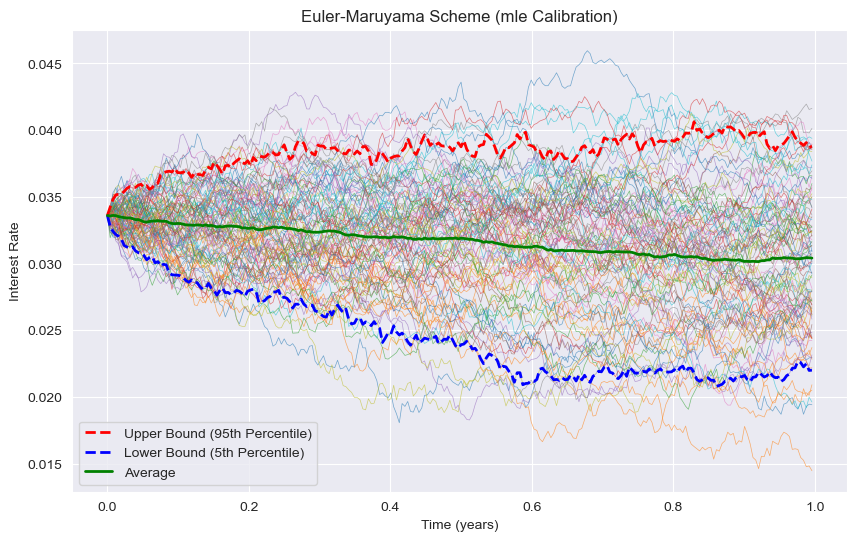


Vasicek Model Parameters (least_squares):
Kappa: 0.7113
Theta: 0.0252
Sigma: 0.0075
Initial Rate (r0): 0.0336


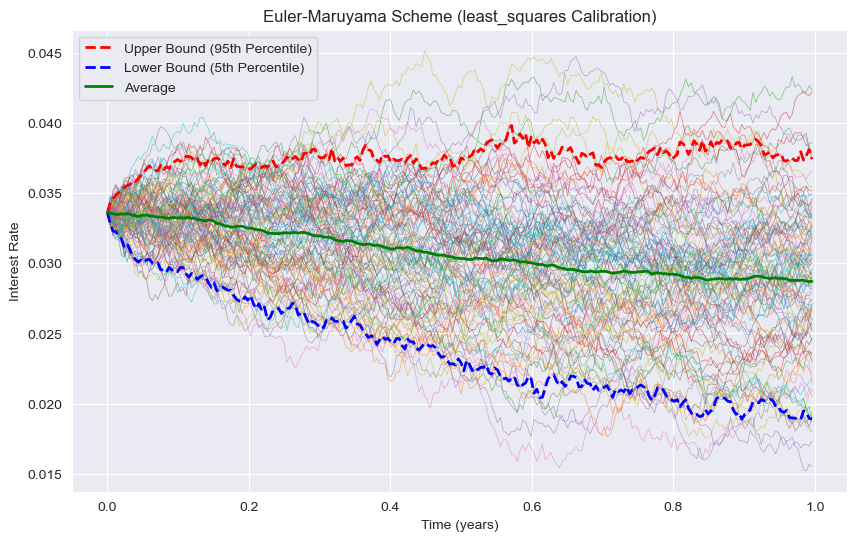

In [3]:
# Initialize the Vasicek model
vasicek = VasicekModel(r0=rates_10y[-1])  # Using the last rate as the initial rate

# Function to calibrate and simulate with both MLE and Least Squares for Euler scheme
def compare_calibrations_and_simulations_euler(rates, method, N, M):
    """
    Compare calibration methods (MLE vs Least Squares) and simulate paths using the Euler scheme.
    
    Args:
    - rates: Historical rate data for calibration.
    - method: The calibration method ('mle' or 'least_squares').
    - N: Number of time steps for simulation (e.g., 252 for 1 year).
    - M: Number of paths to simulate.
    """
    # Calibrate using the chosen method
    vasicek.calibrate(rates, method=method)
    
    # Print the calibrated parameters
    print(f"\nVasicek Model Parameters ({method}):")
    print(f"Kappa: {vasicek.kappa:.4f}")
    print(f"Theta: {vasicek.theta:.4f}")
    print(f"Sigma: {vasicek.sigma:.4f}")
    print(f"Initial Rate (r0): {vasicek.r0:.4f}")
    
    # Simulate paths using the Euler scheme
    simulated_paths_euler = vasicek.simulate_paths(M, N)
    vasicek.plot_simulation(simulated_paths_euler, title=f"Euler-Maruyama Scheme ({method} Calibration)")

# Number of time steps and paths
N = 252  # 1 year
M = 100  # Number of simulated paths

# Compare calibration and simulations for MLE
compare_calibrations_and_simulations_euler(rates_10y.values, method="mle", N=N, M=M)

# Compare calibration and simulations for Least Squares
compare_calibrations_and_simulations_euler(rates_10y.values, method="least_squares", N=N, M=M)